### Loading required libraries

In [83]:
# Loading required libraries

#special IPython command to prepare the notebook for matplotlib
%matplotlib inline

#test file related libraries
import glob
import csv

#import libraries
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from statsmodels.nonparametric.api import lowess
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import sklearn.decomposition
import sklearn.cluster
from matplotlib import gridspec
#import seaborn as sns
import datetime

#set default plot characterstics and colors
from matplotlib import rcParams

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# Supressing the print output of warnings
import warnings
warnings.filterwarnings("ignore")

### Checking for discrepancies in the original text files
During a quick observation, it was noted that in some records the dock_name column had spurious values and these need to be cleaded before going ahead to the next stage of the analysis

In [2]:
#filenames = glob.glob('./Raw/*.csv')
#filenames

In [3]:
#def chkforissues(filename):
#    with open(filename, 'r') as fi:
#        reader = csv.DictReader(fi, delimiter='\t')
#        for line in reader:
#            if len(line['dock_name']) < 2:
#                print line

#for i in filenames:
#    print i
#    chkforissues(i)

### Doing checks on the March 2015 file for choosing the stations

In [4]:
# Loading the data
datamar2015 = pd.read_csv('Raw/bikeshare_nyc_raw_032015.csv', sep='\t')
print(datamar2015.shape)
print(datamar2015.columns)

(1372284, 13)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service',
       'status_key'],
      dtype='object')


In [5]:
# Checking for first few observations
datamar2015.head()

,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,72,W 52 St & 11 Ave,15-03-01,1,6,0,8,31,39,40.767272,-73.993929,1,1
1,72,W 52 St & 11 Ave,15-03-01,1,16,0,8,31,39,40.767272,-73.993929,1,1
2,72,W 52 St & 11 Ave,15-03-01,1,25,0,8,30,38,40.767272,-73.993929,1,1
3,72,W 52 St & 11 Ave,15-03-01,1,35,0,8,30,38,40.767272,-73.993929,1,1
4,72,W 52 St & 11 Ave,15-03-01,1,45,0,8,30,38,40.767272,-73.993929,1,1


In [6]:
# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
datamar2015 = datamar2015.loc[datamar2015['status_key']==1,:]
print(datamar2015.shape)

(1332133, 13)


In [7]:
# Computing the number of 1 hour intervals for the month of March 2015
ts = pd.Series(pd.date_range('3/1/2015','4/1/2015', freq='60min'))
print(len(ts)-1)

744


>__"In the month of march 2015, there should be ideally about 744 one hour intervals and from the data loaded above, respective checks are made whether station id have data across all these hour intervals."__

In [8]:
# Checking for unique date levels
print(len(datamar2015['date'].unique()))

31


>__"31 unique date values are noted in the loaded dataset which is equivalent to number of days for March 2015."__

In [9]:
datamar2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332133 entries, 0 to 1372281
Data columns (total 13 columns):
dock_id        1332133 non-null int64
dock_name      1332133 non-null object
date           1332133 non-null object
hour           1332133 non-null int64
minute         1332133 non-null int64
pm             1332133 non-null int64
avail_bikes    1332133 non-null int64
avail_docks    1332133 non-null int64
tot_docks      1332133 non-null int64
_lat           1332133 non-null float64
_long          1332133 non-null float64
in_service     1332133 non-null int64
status_key     1332133 non-null int64
dtypes: float64(2), int64(9), object(2)
memory usage: 142.3+ MB


In [10]:
# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
datamar2015['hour_new'] = (datamar2015['pm']*12)+datamar2015['hour']-1

In [11]:
# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
#hr12tohr24 = {0:{1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9, 11:10, 12:11}, 
#              1:{1:12, 2:13, 3:14, 4:15, 5:16, 6:17, 7:18, 8:19, 9:20, 10:21, 11:22, 12:23}}

#def create24hr(row):
#    val1 = row['pm']
#    val2 = row['hour']
#    d = hr12tohr24[val1][val2]
#    return d

#datamar2015['hour_new'] = datamar2015.apply(create24hr, axis=1)

In [12]:
# Checking for unique hour levels
print(len(datamar2015['hour_new'].unique()))

24


In [13]:
out = datamar2015.groupby(['pm','hour','hour_new']).size()
print(len(out))
#print out

24


>__"24 unique hour values are noted in the loaded dataset which validates the mapping task performed earlier."__

In [14]:
24*31

744

In [15]:
# Checking for whether station_ids have required one hour intervals in the data
docks = datamar2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = datamar2015[datamar2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

In [16]:
# Selecting only those station ids within 20% of 744 intervals
mar2015_docks = units.loc[units['intervals']>int(744-0.20*744),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(datamar2015['dock_id'].unique()))
print(len(mar2015_docks))

#datamar2015_final = datamar2015[datamar2015['dock_id'].isin(mar2015_docks)]
#print len(datamar2015_final['dock_id'].unique())

328
324


### Doing similar checks across other months and identifying stations with data across all months

#### April 2015

In [17]:
# Computing the number of 1 hour intervals for the month of April 2015
ts = pd.Series(pd.date_range('4/1/2015','5/1/2015', freq='60min'))
print(len(ts)-1)

720


In [18]:
# Loading the data
dataapr2015 = pd.read_csv('Raw/bikeshare_nyc_raw_042015.csv', sep='\t')
print(dataapr2015.shape)
print(dataapr2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
dataapr2015 = dataapr2015.loc[dataapr2015['status_key']==1,:]
print(dataapr2015.shape)

# Checking for first few observations
dataapr2015.head()

(1224511, 13)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service',
       'status_key'],
      dtype='object')
(1191059, 13)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,116,W 17 St & 8 Ave,15-04-02,2,52,1,5,32,32,40.741776,-74.001497,1,1
1,116,W 17 St & 8 Ave,15-04-02,3,3,1,1,36,36,40.741776,-74.001497,1,1
2,116,W 17 St & 8 Ave,15-04-02,3,13,1,2,35,35,40.741776,-74.001497,1,1
3,116,W 17 St & 8 Ave,15-04-02,3,24,1,3,34,34,40.741776,-74.001497,1,1
4,116,W 17 St & 8 Ave,15-04-02,3,35,1,2,35,35,40.741776,-74.001497,1,1


In [19]:
# Checking for unique date levels
print(len(dataapr2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
dataapr2015['hour_new'] = (dataapr2015['pm']*12)+dataapr2015['hour']-1

# Checking for unique hour levels
print(len(dataapr2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = dataapr2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = dataapr2015[dataapr2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

29
24


In [20]:
# Selecting only those station ids within 20% of 720 intervals
apr2015_docks = units.loc[units['intervals']>int(720-0.20*720),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(dataapr2015['dock_id'].unique()))
print(len(apr2015_docks))


# Finding intersection with mar2015 dck_ids
def intersect(a, b):
    return list(set(a) & set(b))

apr2015_docks = intersect(apr2015_docks, mar2015_docks)
print(len(apr2015_docks))

328
315
313


#### May 2015

In [21]:
# Computing the number of 1 hour intervals for the month of May 2015
ts = pd.Series(pd.date_range('5/1/2015','6/1/2015', freq='60min'))
print(len(ts)-1)

744


In [22]:
# Loading the data
datamay2015 = pd.read_csv('Raw/bikeshare_nyc_raw_052015.csv', sep='\t')
print(datamay2015.shape)
print(datamay2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
datamay2015 = datamay2015.loc[datamay2015['status_key']==1,:]
print(datamay2015.shape)

# Checking for first few observations
datamay2015.head()

(1391635, 13)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service',
       'status_key'],
      dtype='object')
(1343617, 13)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
1791,116,W 17 St & 8 Ave,15-05-14,1,1,0,2,37,39,40.741776,-74.0015,1,1
1792,116,W 17 St & 8 Ave,15-05-14,1,9,0,2,37,39,40.741776,-74.0015,1,1
1793,116,W 17 St & 8 Ave,15-05-14,1,18,0,2,37,39,40.741776,-74.0015,1,1
1794,116,W 17 St & 8 Ave,15-05-14,1,26,0,2,37,39,40.741776,-74.0015,1,1
1795,116,W 17 St & 8 Ave,15-05-14,1,38,0,1,38,39,40.741776,-74.0015,1,1


In [23]:
# Checking for unique date levels
print(len(datamay2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
datamay2015['hour_new'] = (datamay2015['pm']*12)+datamay2015['hour']-1

# Checking for unique hour levels
print(len(datamay2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = datamay2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = datamay2015[datamay2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

31
24


In [24]:
# Selecting only those station ids within 20% of 744 intervals
may2015_docks = units.loc[units['intervals']>int(744-0.20*744),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(datamay2015['dock_id'].unique()))
print(len(may2015_docks))

# Intersecting with apr2015 station list
may2015_docks = intersect(may2015_docks, apr2015_docks)
print(len(may2015_docks))

327
314
304


#### June 2015

In [25]:
# Computing the number of 1 hour intervals for the month of June 2015
ts = pd.Series(pd.date_range('6/1/2015','7/1/2015', freq='60min'))
print(len(ts)-1)

720


In [26]:
# Loading the data
datajun2015 = pd.read_csv('Raw/bikeshare_nyc_raw_062015.csv', sep='\t')
print(datajun2015.shape)
print(datajun2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
datajun2015 = datajun2015.loc[datajun2015['status_key']==1,:]
print(datajun2015.shape)

# Dropping extra columns
datajun2015 = datajun2015.ix[:, 0:13]

# Checking for first few observations
datajun2015.head()

(1262290, 14)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service', 'status_key',
       'avail_bikes3'],
      dtype='object')
(1232371, 14)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,116,W 17 St & 8 Ave,15-06-01,1,26,1,8,31,39,40.741776,-74.001497,1,1
1,116,W 17 St & 8 Ave,15-06-01,2,8,1,14,25,39,40.741776,-74.001497,1,1
2,116,W 17 St & 8 Ave,15-06-01,7,14,1,5,33,39,40.741776,-74.001497,1,1
3,116,W 17 St & 8 Ave,15-06-01,7,26,1,4,34,39,40.741776,-74.001497,1,1
4,116,W 17 St & 8 Ave,15-06-01,7,37,1,3,35,39,40.741776,-74.001497,1,1


In [27]:
# Checking for unique date levels
print(len(datajun2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
datajun2015['hour_new'] = (datajun2015['pm']*12)+datajun2015['hour']-1

# Checking for unique hour levels
print(len(datajun2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = datajun2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = datajun2015[datajun2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

30
24


In [28]:
# Selecting only those station ids within 20% of 720 intervals
jun2015_docks = units.loc[units['intervals']>int(720-0.20*720),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(datajun2015['dock_id'].unique()))
print(len(jun2015_docks))

# Intersecting with may2015 station list
jun2015_docks = intersect(jun2015_docks, may2015_docks)
print(len(jun2015_docks))

323
318
303


#### July 2015

In [29]:
# Computing the number of 1 hour intervals for the month of July 2015
ts = pd.Series(pd.date_range('7/1/2015','8/1/2015', freq='60min'))
print(len(ts)-1)

744


In [30]:
# Loading the data
datajul2015 = pd.read_csv('Raw/bikeshare_nyc_raw_072015.csv', sep='\t')
print(datajul2015.shape)
print(datajul2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
datajul2015 = datajul2015.loc[datajul2015['status_key']==1,:]
print(datajul2015.shape)

# Checking for first few observations
datajul2015.head()

(952788, 13)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service',
       'status_key'],
      dtype='object')
(940588, 13)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,72,W 52 St & 11 Ave,15-07-01,1,11,0,28,9,39,40.767272,-73.99392888,1,1
1,72,W 52 St & 11 Ave,15-07-01,1,21,0,31,8,39,40.767272,-73.99392888,1,1
2,72,W 52 St & 11 Ave,15-07-01,1,44,0,31,8,39,40.767272,-73.99392888,1,1
3,72,W 52 St & 11 Ave,15-07-01,2,16,0,30,9,39,40.767272,-73.99392888,1,1
4,72,W 52 St & 11 Ave,15-07-01,2,43,0,30,9,39,40.767272,-73.99392888,1,1


In [31]:
# Checking for unique date levels
print(len(datajul2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
datajul2015['hour_new'] = (datajul2015['pm']*12)+datajul2015['hour']-1

# Checking for unique hour levels
print(len(datajul2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = datajul2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = datajul2015[datajul2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

30
24


In [32]:
# Selecting only those station ids within 20% of 744 intervals
jul2015_docks = units.loc[units['intervals']>int(744-0.20*744),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(datajul2015['dock_id'].unique()))
print(len(jul2015_docks))

# Intersecting with jun2015 station list
jul2015_docks = intersect(jul2015_docks, jun2015_docks)
print(len(jul2015_docks))

329
320
297


#### August 2015

In [33]:
# Computing the number of 1 hour intervals for the month of August 2015
ts = pd.Series(pd.date_range('8/1/2015','9/1/2015', freq='60min'))
print(len(ts)-1)

744


In [34]:
# Loading the data
dataaug2015 = pd.read_csv('Raw/bikeshare_nyc_raw_082015.csv', sep='\t')
print(dataaug2015.shape)
print(dataaug2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
dataaug2015 = dataaug2015.loc[dataaug2015['status_key']==1,:]
print(dataaug2015.shape)

# Dropping extra columns
dataaug2015 = dataaug2015.ix[:, 0:13]

# Checking for first few observations
dataaug2015.head()

(1087893, 14)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service', 'status_key',
       'dock_name6'],
      dtype='object')
(781447, 14)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,72,W 52 St & 11 Ave,15-08-01,1,0,0,25,11,39,40.767272,-73.993929,1,1
1,72,W 52 St & 11 Ave,15-08-01,1,21,0,24,12,39,40.767272,-73.993929,1,1
2,72,W 52 St & 11 Ave,15-08-01,1,44,0,25,11,39,40.767272,-73.993929,1,1
3,72,W 52 St & 11 Ave,15-08-01,2,37,0,25,11,39,40.767272,-73.993929,1,1
4,72,W 52 St & 11 Ave,15-08-01,3,3,0,25,11,39,40.767272,-73.993929,1,1


In [35]:
# Checking for unique date levels
print(len(dataaug2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
dataaug2015['hour_new'] = (dataaug2015['pm']*12)+dataaug2015['hour']-1

# Checking for unique hour levels
print(len(dataaug2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = dataaug2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = dataaug2015[dataaug2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

28
24


In [36]:
# Selecting only those station ids within 20% of 744 intervals
aug2015_docks = units.loc[units['intervals']>int(744-0.20*744),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(dataaug2015['dock_id'].unique()))
print(len(aug2015_docks))

# Intersecting with jul2015 station list
aug2015_docks = intersect(aug2015_docks, jul2015_docks)
print(len(aug2015_docks))

418
315
287


#### September 2015

In [37]:
# Computing the number of 1 hour intervals for the month of September 2015
ts = pd.Series(pd.date_range('9/1/2015','10/1/2015', freq='60min'))
print(len(ts)-1)

720


In [38]:
# Loading the data
datasep2015 = pd.read_csv('Raw/bikeshare_nyc_raw_092015.csv', sep='\t')
print(datasep2015.shape)
print(datasep2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
datasep2015 = datasep2015.loc[datasep2015['status_key']==1,:]
print(datasep2015.shape)

# Dropping extra columns
datasep2015 = datasep2015.ix[:, 0:13]

# Checking for first few observations
datasep2015.head()

(1146022, 14)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service', 'status_key',
       'dock_name6'],
      dtype='object')
(991497, 14)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,72,W 52 St & 11 Ave,15-09-01,1,4,0,22,13,39,40.767272,-73.993929,1,1
1,72,W 52 St & 11 Ave,15-09-01,1,22,0,22,13,39,40.767272,-73.993929,1,1
2,72,W 52 St & 11 Ave,15-09-01,1,39,0,22,13,39,40.767272,-73.993929,1,1
3,72,W 52 St & 11 Ave,15-09-01,2,1,0,22,13,39,40.767272,-73.993929,1,1
4,72,W 52 St & 11 Ave,15-09-01,2,17,0,22,13,39,40.767272,-73.993929,1,1


In [39]:
# Checking for unique date levels
print(len(datasep2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
datasep2015['hour_new'] = (datasep2015['pm']*12)+datasep2015['hour']-1

# Checking for unique hour levels
print(len(datasep2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = datasep2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = datasep2015[datasep2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

30
24


In [40]:
# Selecting only those station ids within 20% of 720 intervals
sep2015_docks = units.loc[units['intervals']>int(720-0.20*720),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(datasep2015['dock_id'].unique()))
print(len(sep2015_docks))

# Intersecting with aug2015 station list
sep2015_docks = intersect(sep2015_docks, aug2015_docks)
print(len(sep2015_docks))

488
398
277


#### October 2015

In [41]:
# Computing the number of 1 hour intervals for the month of October 2015
ts = pd.Series(pd.date_range('10/1/2015','11/1/2015', freq='60min'))
print(len(ts)-1)

744


In [42]:
# Loading the data
dataoct2015 = pd.read_csv('Raw/bikeshare_nyc_raw_102015.csv', sep='\t')
print(dataoct2015.shape)
print(dataoct2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
dataoct2015 = dataoct2015.loc[dataoct2015['status_key']==1,:]
print(dataoct2015.shape)

# Dropping extra columns
dataoct2015 = dataoct2015.ix[:, 0:13]

# Checking for first few observations
dataoct2015.head()

(1407804, 15)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service', 'status_key',
       'dock_name6', 'avail_bikes3'],
      dtype='object')
(1333796, 15)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,72,W 52 St & 11 Ave,15-10-01,1,30,0,15,24,39,40.767272,-73.993929,1,1
1,72,W 52 St & 11 Ave,15-10-01,2,30,0,16,23,39,40.767272,-73.993929,1,1
2,72,W 52 St & 11 Ave,15-10-01,2,42,0,16,23,39,40.767272,-73.993929,1,1
3,72,W 52 St & 11 Ave,15-10-01,3,14,0,16,23,39,40.767272,-73.993929,1,1
4,72,W 52 St & 11 Ave,15-10-01,3,20,0,16,23,39,40.767272,-73.993929,1,1


In [43]:
# Checking for unique date levels
print(len(dataoct2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
dataoct2015['hour_new'] = (dataoct2015['pm']*12)+dataoct2015['hour']-1

# Checking for unique hour levels
print(len(dataoct2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = dataoct2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = dataoct2015[dataoct2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

29
24


In [44]:
# Selecting only those station ids within 20% of 744 intervals
oct2015_docks = units.loc[units['intervals']>int(744-0.20*744),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(dataoct2015['dock_id'].unique()))
print(len(oct2015_docks))

# Intersecting with sep2015 station list
oct2015_docks = intersect(oct2015_docks, sep2015_docks)
print(len(oct2015_docks))

497
451
254


#### November 2015

In [45]:
# Computing the number of 1 hour intervals for the month of November 2015
ts = pd.Series(pd.date_range('11/1/2015','12/1/2015', freq='60min'))
print(len(ts)-1)

720


In [46]:
# Loading the data
datanov2015 = pd.read_csv('Raw/bikeshare_nyc_raw_112015.csv', sep='\t')
print(datanov2015.shape)
print(datanov2015.columns)

# {"1":"In Service","2":"Planned","3":"Not In Service","4":"De-registered"}
# Subsetting records only for valid station status key
datanov2015 = datanov2015.loc[datanov2015['status_key']==1,:]
print(datanov2015.shape)

# Dropping extra columns
datanov2015 = datanov2015.ix[:, 0:13]

# Checking for first few observations
datanov2015.head()

(1511309, 16)
Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', '_lat', '_long', 'in_service', 'status_key',
       'dock_name6', 'dock_name7', 'lat3'],
      dtype='object')
(1460332, 16)


,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,72,W 52 St & 11 Ave,15-11-01,1,0,0,23,16,39,40.767272,-73.99393,1,1
1,72,W 52 St & 11 Ave,15-11-01,1,1,0,23,16,39,40.767272,-73.99393,1,1
2,72,W 52 St & 11 Ave,15-11-01,1,13,0,24,15,39,40.767272,-73.99393,1,1
3,72,W 52 St & 11 Ave,15-11-01,1,13,0,23,16,39,40.767272,-73.99393,1,1
4,72,W 52 St & 11 Ave,15-11-01,1,25,0,24,15,39,40.767272,-73.99393,1,1


In [47]:
# Checking for unique date levels
print(len(datanov2015['date'].unique()))

# Given hour column is based on 12 hour interval
# Creating new hour column for 24 hour interval
datanov2015['hour_new'] = (datanov2015['pm']*12)+datanov2015['hour']-1

# Checking for unique hour levels
print(len(datanov2015['hour_new'].unique()))

# Checking for whether station_ids have required one hour intervals in the data
docks = datanov2015['dock_id'].unique()
#len(docks)
units = {}
for dock in docks:
    test = datanov2015[datanov2015['dock_id']==dock]
    unitlen = len(test.groupby(['date','hour_new']).size())
    units[dock] = unitlen
    
units = pd.DataFrame.from_dict(units, orient='index')
units = units.reset_index()
units.columns = ['dock_id', 'intervals']
#units.sort('dock_id', ascending=True)[:10]

30
24


In [48]:
# Selecting only those station ids within 20% of 720 intervals
nov2015_docks = units.loc[units['intervals']>int(720-0.20*720),'dock_id'].tolist()

# Checking for differences from actual dock_id numbers
print(len(datanov2015['dock_id'].unique()))
print(len(nov2015_docks))

# Intersecting with nov2015 station list
nov2015_docks = intersect(nov2015_docks, oct2015_docks)
print(len(nov2015_docks))

501
492
253


### Subsetting for final set of stations across all months

In [49]:
filenames = [datamar2015, dataapr2015, datamay2015, 
             datajun2015, datajul2015, dataaug2015, 
             datasep2015, dataoct2015, datanov2015]

final_docks = nov2015_docks
print(len(final_docks))

253


In [50]:
def subsetdocks(filename):
    global data
    data = filename
    data = data[data['dock_id'].isin(final_docks)]
    return data

In [51]:
dockmaster = pd.DataFrame()

for i in range(len(filenames)):
    subsetdocks(filenames[i])
    dockmaster = pd.concat([dockmaster, data], axis=0)

In [52]:
# Doing checks on the merger master file
# Making a copy of master file
dockmaster_1 = dockmaster.copy()
print(dockmaster_1.shape)
print(len(dockmaster_1['dock_id'].unique()))

(7313589, 14)
253


In [53]:
# Checking for data types
dockmaster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7313589 entries, 0 to 964939
Data columns (total 14 columns):
dock_id        int64
dock_name      object
date           object
hour           int64
minute         int64
pm             int64
avail_bikes    object
avail_docks    float64
tot_docks      float64
_lat           float64
_long          object
in_service     float64
status_key     float64
hour_new       int64
dtypes: float64(5), int64(5), object(4)
memory usage: 837.0+ MB


In [54]:
# Checking for first few observations
dockmaster_1.head()

,dock_id,dock_name,date,hour,minute,pm,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key,hour_new
0,72,W 52 St & 11 Ave,15-03-01,1,6,0,8,31,39,40.767272,-73.99393,1,1,0
1,72,W 52 St & 11 Ave,15-03-01,1,16,0,8,31,39,40.767272,-73.99393,1,1,0
2,72,W 52 St & 11 Ave,15-03-01,1,25,0,8,30,38,40.767272,-73.99393,1,1,0
3,72,W 52 St & 11 Ave,15-03-01,1,35,0,8,30,38,40.767272,-73.99393,1,1,0
4,72,W 52 St & 11 Ave,15-03-01,1,45,0,8,30,38,40.767272,-73.99393,1,1,0


In [55]:
# Removing records related to invalid status key column
dockmaster_1['status_key'].value_counts()

1    7313589
dtype: int64

In [56]:
# Dropping unnecessary columns from the data
dockmaster_1.drop(['in_service', 'status_key', '_lat', '_long'], axis=1, inplace=True)
dockmaster_1.shape

(7313589, 10)

### Aggregating the station feed data across one hour intervals

In [57]:
collst = [u'dock_id', u'date', u'pm', u'hour', u'hour_new', u'minute', 
          u'avail_bikes', u'avail_docks', u'tot_docks']

In [58]:
# Making a copy of master file
dockmaster_2 = dockmaster_1.copy()
print(dockmaster_2.shape)

# Subset only for required columns
dockmaster_2 = dockmaster_2[collst]
print(dockmaster_2.shape)

(7313589, 10)
(7313589, 9)


In [59]:
# Checking for datatypes
dockmaster_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7313589 entries, 0 to 964939
Data columns (total 9 columns):
dock_id        int64
date           object
pm             int64
hour           int64
hour_new       int64
minute         int64
avail_bikes    object
avail_docks    float64
tot_docks      float64
dtypes: float64(2), int64(5), object(2)
memory usage: 558.0+ MB


In [60]:
# Converting avail_bikes to float
dockmaster_2['avail_bikes'] = dockmaster_2['avail_bikes'].apply(lambda x: float(x))

In [61]:
# Checking for descriptive statistics for avail_bikes, avail_docks, tot_docks columns
dockmaster_2.describe()

,dock_id,pm,hour,hour_new,minute,avail_bikes,avail_docks,tot_docks
count,7313589.000000,7313589.000000,7313589.000000,7313589.000000,7313589.000000,7313587.000000,7313589.000000,7313589.000000
mean,430.565915,0.528802,6.625557,11.971177,29.501664,12.149173,20.733916,33.633029
std,337.905667,0.499170,3.451159,6.826053,17.332662,10.800821,13.014108,10.177426
min,72.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,297.000000,0.000000,4.000000,6.000000,14.000000,3.000000,11.000000,27.000000
50%,385.000000,1.000000,7.000000,12.000000,29.000000,9.000000,20.000000,31.000000
75%,466.000000,1.000000,10.000000,18.000000,45.000000,19.000000,29.000000,39.000000
max,2023.000000,1.000000,12.000000,23.000000,59.000000,226.000000,62.000000,62.000000


>__From the above output, the following insights can be made:__

>__1.__ avail bikes column seems to have two missing values <br>
>__2.__ avail bikes seems to have some extreme values suggested by the max value <br>
>__3.__ avail docks and tot_docks seem to be consistent in terms of range of possible values

In [62]:
dockmaster_2[dockmaster_2['avail_bikes'].isnull()]

,dock_id,date,pm,hour,hour_new,minute,avail_bikes,avail_docks,tot_docks
12298,127,15-04-10,0,9,8,6,NaN,28,28
26598,143,15-06-27,0,11,10,44,NaN,7,24


In [63]:
# Replace missing value for dock_id 127
mean127_na = dockmaster_2.loc[(dockmaster_2['dock_id']==127) &
                              (dockmaster_2['hour_new']==8), 'avail_bikes'].mean()
#print mean127_na

dockmaster_2.loc[(dockmaster_2['avail_bikes'].isnull()) & 
                 (dockmaster_2['dock_id']==127), 'avail_bikes'] = mean127_na

# Replace missing value for dock_id 143
mean143_na = dockmaster_2.loc[(dockmaster_2['dock_id']==143) &
                              (dockmaster_2['hour_new']==10), 'avail_bikes'].mean()
#print mean143_na

dockmaster_2.loc[(dockmaster_2['avail_bikes'].isnull()) & 
                 (dockmaster_2['dock_id']==143), 'avail_bikes'] = mean143_na

In [64]:
# Checking again after replacing missing values
dockmaster_2[[u'avail_bikes', u'avail_docks', u'tot_docks']].describe()

,avail_bikes,avail_docks,tot_docks
count,7313589.000000,7313589.000000,7313589.000000
mean,12.149172,20.733916,33.633029
std,10.800820,13.014108,10.177426
min,0.000000,0.000000,0.000000
25%,3.000000,11.000000,27.000000
50%,9.000000,20.000000,31.000000
75%,19.000000,29.000000,39.000000
max,226.000000,62.000000,62.000000


In [65]:
# Aggreating columns by dock_id and interv
grouped = dockmaster_2.groupby(['dock_id', 'date', 'hour_new'])

aggregations = {'avail_bikes': lambda x: np.mean(x),  
                'avail_docks': lambda x: np.mean(x), 
                'tot_docks': lambda x: np.mean(x)}

hrintervals = grouped.agg(aggregations)
hrintervals.shape

(1529603, 3)

In [66]:
# Converting multiindex to columns
hrintervals = hrintervals.reset_index()
hrintervals.head()

,dock_id,date,hour_new,avail_docks,tot_docks,avail_bikes
0,72,15-03-01,0,30.500000,38.333333,7.833333
1,72,15-03-01,1,30.833333,38.833333,8.000000
2,72,15-03-01,2,30.166667,38.166667,8.000000
3,72,15-03-01,3,30.833333,38.833333,8.000000
4,72,15-03-01,4,30.857143,38.857143,8.000000


In [67]:
#hrintervals.groupby(['dock_id']).size().value_counts()
hrintervals[[u'avail_bikes', u'avail_docks', u'tot_docks']].describe()

,avail_bikes,avail_docks,tot_docks
count,1529603.000000,1529603.000000,1529603.00000
mean,12.424392,20.478471,33.75047
std,10.833860,13.043076,10.09497
min,0.000000,0.000000,0.00000
25%,3.166667,10.000000,27.00000
50%,9.800000,20.000000,32.00000
75%,19.400000,29.000000,39.00000
max,62.000000,62.000000,62.00000


### Doing checks on the tot_docks distribution

In [68]:
hrintervals.columns

Index(['dock_id', 'date', 'hour_new', 'avail_docks', 'tot_docks',
       'avail_bikes'],
      dtype='object')

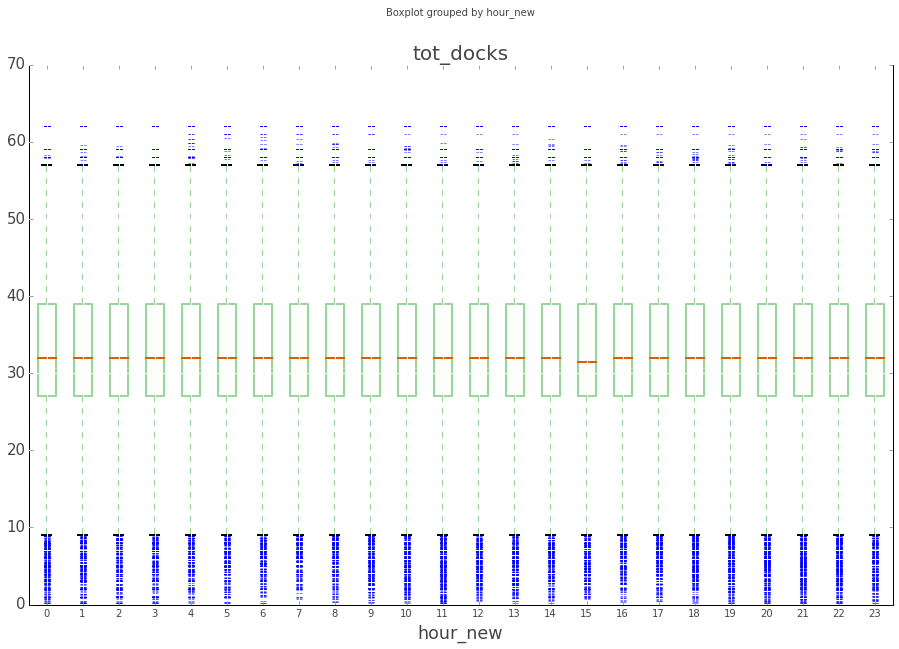

In [84]:
hrintervals.boxplot(column='tot_docks', by='hour_new', figsize=(15,10))

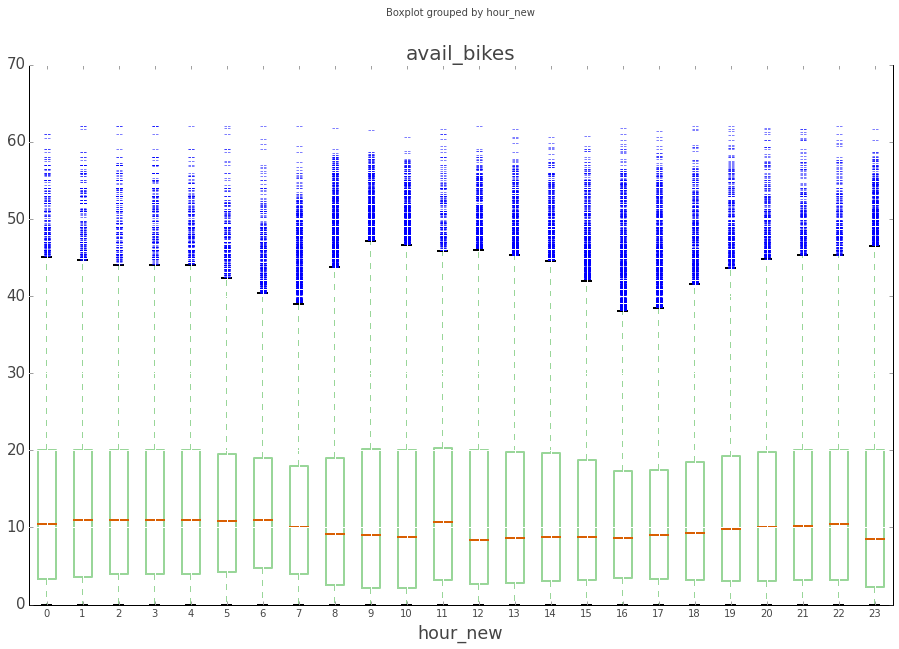

In [85]:
hrintervals.boxplot(column='avail_bikes', by='hour_new', figsize=(15,10))

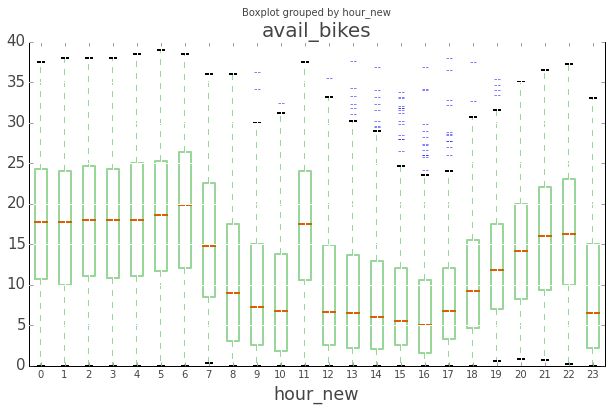

In [86]:
### Doing checks only for dock_id = 72
data72 = hrintervals[hrintervals['dock_id']==72]
data72.boxplot(column='avail_bikes', by='hour_new', figsize=(10,6))

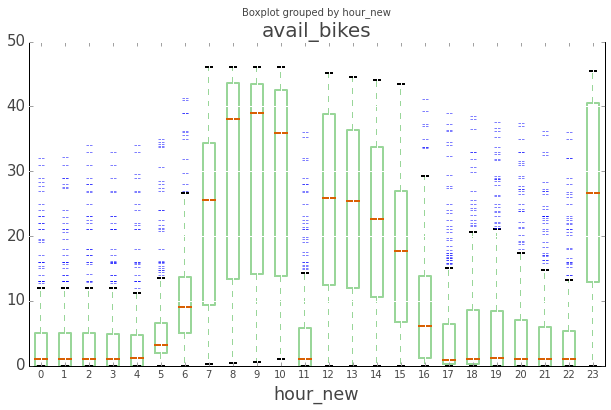

In [87]:
### Doing checks only for dock_id = 137
data137 = hrintervals[hrintervals['dock_id']==137]
data137.boxplot(column='avail_bikes', by='hour_new', figsize=(10,6))

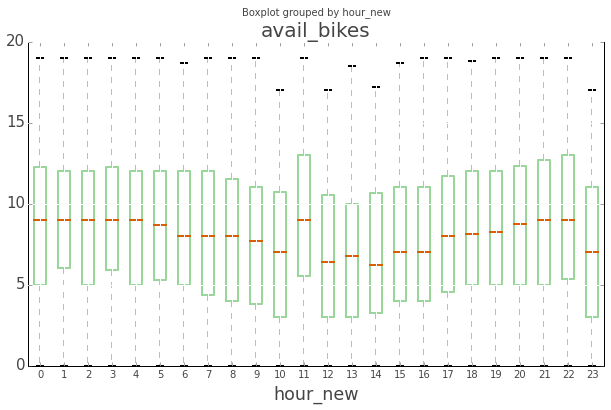

In [88]:
### Doing checks only for dock_id = 119
data119 = hrintervals[hrintervals['dock_id']==119]
data119.boxplot(column='avail_bikes', by='hour_new', figsize=(10,6))

### Exporting the aggregated data

In [71]:
# Exporting to text file to be used for later analysis
hrintervals.to_csv("stationfeed_agg_final.csv", index=False)

### Getting unique station ids and names

In [72]:
# Checking for column names
dockmaster_1.columns

Index(['dock_id', 'dock_name', 'date', 'hour', 'minute', 'pm', 'avail_bikes',
       'avail_docks', 'tot_docks', 'hour_new'],
      dtype='object')

In [73]:
# Extracting station id and station name into separate data
station_names = dockmaster_1.groupby(['dock_id', 'dock_name']).size().reset_index()
print(station_names.shape)
print(len(station_names['dock_id'].unique()))
print(len(station_names['dock_name'].unique()))
station_names.head()

(258, 3)
253
258


,dock_id,dock_name,0
0,72,W 52 St & 11 Ave,28851
1,79,Franklin St & W Broadway,28961
2,82,St James Pl & Pearl St,28953
3,83,Atlantic Ave & Fort Greene Pl,28988
4,119,Park Ave & St Edwards St,28806


In [74]:
# Checking for duplicate records at dock_id level
station_names['dock_id'].value_counts().order(ascending=False)[:5]

399    3
443    2
433    2
242    2
527    1
dtype: int64

In [75]:
station_names[station_names['dock_id']==399]

,dock_id,dock_name,0
139,399,Lafayette Ave & St Jaes Pl,1
140,399,Lafayette Ave & St James Pl,28967
141,399,Laffayette Ave & St James Pl,1


In [76]:
# Drop column and duplicate records
station_names.drop(0, axis=1, inplace=True)
station_names.drop_duplicates('dock_id', inplace=True)
print(station_names.shape)
print(len(station_names['dock_id'].unique()))
print(len(station_names['dock_name'].unique()))
station_names.head()

(253, 2)
253
253


,dock_id,dock_name
0,72,W 52 St & 11 Ave
1,79,Franklin St & W Broadway
2,82,St James Pl & Pearl St
3,83,Atlantic Ave & Fort Greene Pl
4,119,Park Ave & St Edwards St


In [77]:
# Exporting to text file to be used for later analysis
station_names.to_csv("station_names.txt", sep='|', index=False)